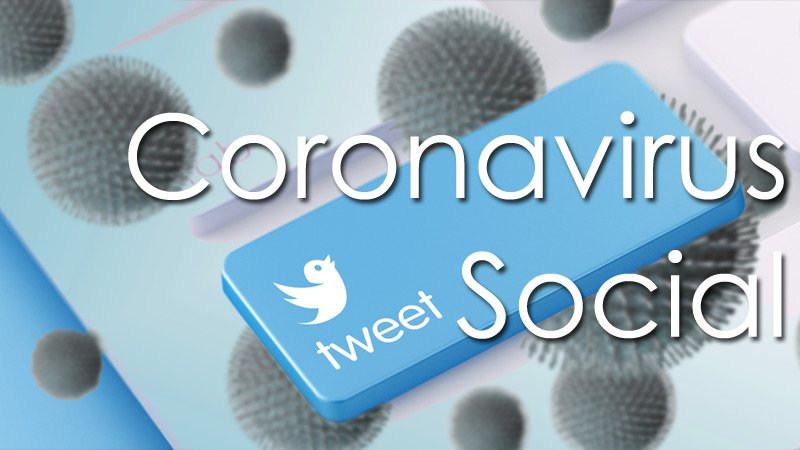

* Coronavirus disease (COVID-19) is an infectious disease caused by a newly discovered coronavirus. Most people who fall sick with COVID-19 will experience mild to moderate symptoms and recover without special treatment.

* In this notebook, we would perform Sentiment Analysis for the Covid-19 Tweets through passing differnet steps such as:
* Data underestanding
* Data Visualization
* WordCloud
* Data Preprocessing for the NLP Natural language processing
* Building different Machine Learning Models
* Model Evaluation

# Importing the necessary libraries:

In [ ]:
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt
import seaborn           as sns
import plotly.graph_objs as go
import plotly.express    as px 

!pip install millify
from millify     import millify
from scipy.stats import norm
from wordcloud   import WordCloud, STOPWORDS
from textblob import TextBlob
import re
from collections import Counter

from sklearn.metrics import classification_report,accuracy_score,confusion_matrix
from IPython.display import Markdown as md

import warnings
warnings.filterwarnings("ignore")

# Data Underestanding

# Improting the dataset into the kernel

In [ ]:
df=pd.read_csv("../input/covid19-tweets/covid19_tweets.csv")
df.head()

In [ ]:
df.shape

In [ ]:
print('There are {} rows and {} columns in the dataset'.format(df.shape[0], df.shape[1]))

In [ ]:
#let's get some information about the data types of our dataset by executing the code below
df.info()

### Missing Values

In [ ]:
#Let's find out about the missing values in the dataset by executing the code below:
df.isna().sum()

# Data Visualization

# Let's visualizing the missing values

In [ ]:
missing_values = pd.DataFrame()
missing_values['column'] = df.columns

missing_values['percent'] = [round(100* df[col].isnull().sum() / len(df), 2) for col in df.columns]
missing_values = missing_values.sort_values('percent')
missing_values = missing_values[missing_values['percent']>0]

In [ ]:
plt.figure(figsize=(15, 5))
sns.set(style='whitegrid', color_codes=True)
splot=sns.barplot(x='column', y='percent', data=missing_values)
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center',
                   va = 'center', xytext = (0, 9), textcoords = 'offset points')
plt.xlabel("Column_Name", size=14, weight="bold")
plt.ylabel("Percentage", size=14, weight="bold")
plt.title("Percentage of missing values in column",fontweight="bold",size=17)
plt.show()

# Observation:
* The above barplot shows us that there are only four columns with missing values
* Percentage of missing values are also shown in the plot

In [ ]:
df_username_count = df['user_name'].value_counts().reset_index().rename(columns={
    'user_name':'tweet_count','index':'user_name'})

In [ ]:
df = pd.merge(df, df_username_count, on='user_name')

# Top50 users by number of followers - Barplot:

In [ ]:
data = df.sort_values('user_followers',ascending=False).drop_duplicates(subset='user_name', keep="first")
data = data[['user_name', 'user_followers', 'tweet_count']]
data.sort_values('user_followers',ascending=False)

data1 = data.head(50).reset_index().copy()
for i in range(50):
    data1['user_followers'][i] = millify(data1['user_followers'][i],precision=2)
    
data1['user_followers'] = data1['user_followers'].str[:-1].astype(float) # To remove 'M'

plt.figure(figsize=(15, 17))
sns.barplot(y='user_name',x='user_followers',data=data1.head(50))
y=data1['user_followers'].head(50)
for index, value in enumerate(y):
    plt.text(value, index, str(value),fontsize=12)
plt.title('Top50 users by number of followers',weight='bold', size=15)
plt.ylabel('User_name', size=12, weight='bold')
plt.xlabel('Followers_count( in Millions )', size=12, weight='bold')
plt.show()

# Frequency of user_name:

In [ ]:
def plot_frequency_charts(df, feature, title, pallete):
    freq_df = pd.DataFrame()
    freq_df[feature] = df[feature]
    
    f, ax = plt.subplots(1,1, figsize=(16,4))
    total = float(len(df))
    g = sns.countplot(df[feature], order = df[feature].value_counts().index[:20], palette=pallete)
    g.set_title("Number and percentage of {}".format(title))

    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(100*height/total),
                ha="center") 

    plt.title('Frequency of {} tweeting about Corona'.format(feature),weight='bold', size=15)
    plt.ylabel('Frequency', size=12, weight='bold')
    plt.xlabel(title, size=12, weight='bold')
    plt.xticks(rotation=90)
    plt.show()

In [ ]:
plot_frequency_charts(df, 'user_name', 'User Names','inferno')

# WordCloud

In [ ]:
df = df.fillna('None')

def wordcloud(string,title,color):
    wc = WordCloud(background_color=color, width=1200,height=600,mask=None,random_state=1,
                   max_font_size=200,stopwords=stop_words,collocations=False).generate(string)
    fig=plt.figure(figsize=(20,8))
    plt.axis('off')
    plt.title('--- WordCloud for {} --- '.format(title),weight='bold', size=30)
    plt.imshow(wc)

In [ ]:
stop_words=set(STOPWORDS)
source_string = " ".join(df['source'].astype('str'))
hastage_string = " ".join(df['hashtags'].astype('str'))
location_string = " ".join(df['user_location'].astype('str'))

In [ ]:
wordcloud(source_string,'Source','white')

# Sentiment Analysis on Covid19 Tweets

* To peform sentiment analysis we need labeled dataset.
* The data can be downloaded from here: https://www.kaggle.com/surajkum1198/twitterdata

In [ ]:
data = pd.read_csv('/kaggle/input/twitterdata/finalSentimentdata2.csv')
data.head()

* Count plot of sentiments,we can see that sad and fear are prevailing which is quite obvious

In [ ]:
sns.countplot(data['sentiment'])

# Data Preprocessing
Now let us preprocess text using some NLP tchniques like:

* converting to lowercase
* remove text in square brackets,
* remove links,
* remove punctuation
* remove words containing numbers
* Removing Punctuation
* Removing stopwords
* Stemming
* Lemmatization

In [ ]:
#importing the necessary libraries for preprocessing of the dataset
import nltk
import re
import string

* A function to clean data it removes all the punctuation marks, urls etc

In [ ]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [ ]:
data['text'] = data['text'].apply(lambda x: clean_text(x))

# Removing the Emoji
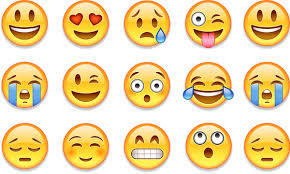

In [ ]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)



In [ ]:
data['text']=data['text'].apply(lambda x: remove_emoji(x))

* Checking the maximum length of tweet

In [ ]:
data['text'].apply(lambda x:len(str(x).split())).max()

# Splitting the dataset

In [ ]:
from sklearn.model_selection import train_test_split

train,valid = train_test_split(data,test_size = 0.2,random_state=0,stratify = data.sentiment.values) #stratification means that the train_test_split method returns training and test subsets that have the same proportions of class labels as the input dataset.
print("train shape : ", train.shape)
print("valid shape : ", valid.shape)

# Vectorizing

* We are going to use CountVectorizer for the following steps

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
stop = list(stopwords.words('english'))
vectorizer = CountVectorizer(decode_error = 'replace',stop_words = stop)

X_train = vectorizer.fit_transform(train.text.values)
X_valid = vectorizer.transform(valid.text.values)

y_train = train.sentiment.values
y_valid = valid.sentiment.values

print("X_train.shape : ", X_train.shape)
print("X_train.shape : ", X_valid.shape)
print("y_train.shape : ", y_train.shape)
print("y_valid.shape : ", y_valid.shape)

# ML model building

## Grid Search
All you need to do in GridSearch is tell it which hyperparameters you want it to experiment with, and what values to try out, and it will evaluate all the possible combinations of hyperparameter values, using cross-validation.

## Randomized Search
the grid search approach is fine when you are exploring relatevely few combinations, but when the hyperparameter search space is large, it is often preferable to use `RandomizedSearchCV` instead. This technique evaluates a given number of random combinations by selecting a random value for each hyperparameter at every iteration. This approach has two main benefits:
- If you let the randomized search run for 1000 iterations it will explore 1000 different values for each hyperparameter.
- You have more control over the computing budget you want to allocate to hyperparameter search, simply by setting the number of iterations.

# 1. Logistic Regression

Logistic regression does not really have any critical hyperparameters to tune.

Sometimes, you can see useful differences in performance or convergence with different solvers (solver).
- **solver** in `[‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga’]`

Regularization (penalty) can sometimes be helpful.
- **penalty** in `[‘none’, ‘l1’, ‘l2’, ‘elasticnet’]`

**Note:** not all solvers support all regularization terms.

- The **C** parameter controls the penality strength, which can also be effective. **C** in `[100, 10, 1.0, 0.1, 0.01]`

The example below demonstrates grid searching the key hyperparameters for LogisticRegression on a synthetic binary classification dataset.

In [ ]:
# example of grid searching key hyperparametres for logistic regression
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression



# define models and parameters
model = LogisticRegression()
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01, 0.001]

# define grid search
grid = dict(solver=solvers, penalty=penalty, C=c_values)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, 
                           scoring='accuracy',error_score=0, iid=True)
grid_result = grid_search.fit(X_train, y_train)

# summarize results
print(f"Best: {grid_result.best_score_:.3f} using {grid_result.best_params_}")

# 2. Ridge Classifier

Ridge regression is a penalized linear regression model for predicting a numerical value.

Nevertheless, it can be very effective when applied to classification.

Perhaps the most important parameter to tune is the regularization strength (alpha). A good starting point might be values in the range `[0.1 to 1.0]`

- alpha in `[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]`

In [ ]:
from sklearn.linear_model import RidgeClassifier

# define models and parameters
model = RidgeClassifier()
alpha = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

# define grid search
grid = dict(alpha=alpha)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, 
                           scoring='accuracy',error_score=0, iid=True)
grid_result = grid_search.fit(X_train, y_train)

# summarize results
print(f"Best: {grid_result.best_score_:.3f} using {grid_result.best_params_}")

# 3. K-Nearest Neighbors (KNN)

The most important hyperparameter for KNN is the number of neighbors (n_neighbors).

Test values between at least `1` and `21`, perhaps just the odd numbers.

- n_neighbors in `[1 to 21]`

It may also be interesting to test different distance metrics (metric) for choosing the composition of the neighborhood.

- metric in `[‘euclidean’, ‘manhattan’, ‘minkowski’]`

It may also be interesting to test the contribution of members of the neighborhood via different weightings (weights).

- weights in `[‘uniform’, ‘distance’]`

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# define models and parameters
model = KNeighborsClassifier()
n_neighbors = range(1, 21, 2)
weights = ['uniform', 'distance']
metric = ['euclidean', 'manhattan', 'minkowski']

# define grid search
grid = dict(n_neighbors=n_neighbors,weights=weights,metric=metric)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, 
                           scoring='accuracy',error_score=0, iid=True)
grid_result = grid_search.fit(X_train, y_train)

# summarize results
print(f"Best: {grid_result.best_score_:.3f} using {grid_result.best_params_}")

# Naive Bayes

In [ ]:
from sklearn.naive_bayes import MultinomialNB

naiveByes_clf = MultinomialNB()

naiveByes_clf.fit(X_train,y_train)

NB_prediction = naiveByes_clf.predict(X_valid)
NB_accuracy = accuracy_score(y_valid,NB_prediction)
print("training accuracy Score    : ",naiveByes_clf.score(X_train,y_train))
print("Validation accuracy Score : ",NB_accuracy )
print(classification_report(NB_prediction,y_valid))

# Stochastic Gradient Descent

In [ ]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(loss = 'hinge', penalty = 'l2', random_state=0)

sgd_clf.fit(X_train,y_train)

sgd_prediction = sgd_clf.predict(X_valid)
sgd_accuracy = accuracy_score(y_valid,sgd_prediction)
print("Training accuracy Score    : ",sgd_clf.score(X_train,y_train))
print("Validation accuracy Score : ",sgd_accuracy )
print(classification_report(sgd_prediction,y_valid))

# Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier()

rf_clf.fit(X_train,y_train)

rf_prediction = rf_clf.predict(X_valid)
rf_accuracy = accuracy_score(y_valid,rf_prediction)
print("Training accuracy Score    : ",rf_clf.score(X_train,y_train))
print("Validation accuracy Score : ",rf_accuracy )
print(classification_report(rf_prediction,y_valid))

# Extreme Gradient Boosting

In [ ]:
#takes huge amount of time to execute
import xgboost as xgb

xgboost_clf = xgb.XGBClassifier()

xgboost_clf.fit(X_train, y_train)

xgb_prediction = xgboost_clf.predict(X_valid)
xgb_accuracy = accuracy_score(y_valid,xgb_prediction)
print("Training accuracy Score    : ",xgboost_clf.score(X_train,y_train))
print("Validation accuracy Score : ",xgb_accuracy )
print(classification_report(xgb_prediction,y_valid))

# Support Vector Machine

In [ ]:
from sklearn.svm import SVC

svc = SVC()

svc.fit(X_train, y_train)

svc_prediction = svc.predict(X_valid)
svc_accuracy = accuracy_score(y_valid,svc_prediction)
print("Training accuracy Score    : ",svc.score(X_train,y_train))
print("Validation accuracy Score : ",svc_accuracy )
print(classification_report(svc_prediction,y_valid))

# Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()

logreg.fit(X_train, y_train)

logreg_prediction = logreg.predict(X_valid)
logreg_accuracy = accuracy_score(y_valid,logreg_prediction)
print("Training accuracy Score    : ",logreg.score(X_train,y_train))
print("Validation accuracy Score : ",logreg_accuracy )
print(classification_report(logreg_prediction,y_valid))

In [ ]:
models = pd.DataFrame({
    'Model': ['Support Vector Machines', 'Logistic Regression', 
              'Random Forest', 'Naive Bayes', 
              'Stochastic Gradient Decent', 'XGBoost'],
    'Test accuracy': [svc_accuracy, logreg_accuracy, 
              rf_accuracy, NB_accuracy, 
              sgd_accuracy, xgb_accuracy,]})

models.sort_values(by='Test accuracy', ascending=False)